In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!pip install phenograph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 159 kB 3.4 MB/s 
     |████████████████████████████████| 1.3 MB 30.5 MB/s 
     |████████████████████████████████| 3.1 MB 35.7 MB/s 


In [2]:
# import packages
from keras.layers import Input, Dense
from tensorflow.keras.models import Model

import numpy as np
import pandas as pd

import tensorflow as tf
import keras

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
# visualization
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

def myscatter(Y, class_idxs, legend=False, ran=True, seed=229):
    if ran:
        np.random.seed(seed)
    Y = np.array(Y)
    fig, ax = plt.subplots(figsize=(6,4), dpi=300)
    classes = list(np.unique(class_idxs))
    markers = 'osD' * len(classes)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(classes)))
    if ran:
        np.random.shuffle(colors)

    for i, cls in enumerate(classes):
        mark = markers[i]
        ax.plot(Y[class_idxs == cls, 0], Y[class_idxs == cls, 1], marker=mark,
                linestyle='', ms=4, label=str(cls), alpha=1, color=colors[i],
                markeredgecolor='black', markeredgewidth=0.15)
    if legend:
        ax.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0, fontsize=10, markerscale=2, frameon=False,
                  ncol=2, handletextpad=0.1, columnspacing=0.5)

    plt.xticks([])
    plt.yticks([])

    return ax

In [4]:
# t-SNE
def tsne(X, dim=2, ran=23):
    t_sne = TSNE(n_components=dim, random_state=ran)
    Y_tsne = t_sne.fit_transform(X)
    return Y_tsne

In [7]:
# clustering layer

from tensorflow.keras import activations, constraints, initializers, regularizers
from tensorflow.keras.layers import Layer, InputSpec
import tensorflow.keras.backend as K
import phenograph
from sklearn.cluster import KMeans

class ClusteringLayer(Layer):
    def __init__(self, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=None, initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def target_distribution(q):
    q = q.numpy()
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

def computeCentroids(data, labels):
    n_clusters = len(np.unique(labels))
    return np.array([data[labels == i].mean(0) for i in range(n_clusters)])

def get_centers(H, mode="kmeans", n_cluster=10):
    if mode == "louvain":
        l, _,  _ = phenograph.cluster(H)
    elif mode == "kmeans":
        l = KMeans(n_clusters=n_cluster, random_state=0).fit(h).labels_
    centers = computeCentroids(H, l)
    return centers, l

In [ ]:
# read data
cells = np.array(pd.read_csv("colon_cell_info.csv", index_col=0, sep="\t"))
count = np.array(pd.read_csv("colon_normalize.csv", index_col=0, sep=","))

In [ ]:
# read data
cells = np.array(pd.read_csv("idents3_raw.csv", index_col=0, sep="\t"))
count = np.array(pd.read_csv("data3_raw.csv", index_col=0, sep="\t"))

In [ ]:
count = np.array(pd.read_csv("AML-029-08-1E_data.csv", index_col=0, sep="\t"))

In [ ]:
# read data
cells = np.array(pd.read_csv("GSM3587923_AML1012-D0_info_new.csv", index_col=0, sep="\t"))
count = np.array(pd.read_csv("GSM3587923_AML1012-D0_normalize.csv", index_col=0, sep=","))

In [26]:
# read data
cells = np.array(pd.read_csv("/content/drive/My Drive/CompBio/GSM3587923_AML1012-D0_info_new.csv", index_col=0, sep="\t"))
count = np.array(pd.read_csv("/content/drive/My Drive/CompBio/GSM3587923_AML1012-D0_normalize.csv", index_col=0, sep=","))

In [ ]:
# read data
cells = np.array(pd.read_csv("/content/drive/My Drive/CompBio/GSM3587960_AML475-D0_info_new.csv", index_col=0, sep="\t"))
count = np.array(pd.read_csv("/content/drive/My Drive/CompBio/GSM3587960_AML475-D0_normalize.csv", index_col=0, sep=","))

In [27]:
# preprocessing
[n_sample, n_gene] = count.shape
cells = cells.flatten()
x_train = count.astype('float32')

In [52]:
from tensorflow.keras.losses import MSE, KLD
from keras.constraints import NonNeg
class AE(tf.keras.Model):

    def __init__(self, X, hidden_dim=[], latent_dim=50, impute_dim=64):
        super(AE, self).__init__()
        self.X = X

        # encoder
        
        #encoder_in = Input(shape=n_gene)
        #encoded1 = Dense(hidden_dim, activation = "relu", use_bias=True)(encoder_in)
        #encoded2 = Dense(latent_dim, activation = "relu", use_bias=True)(encoded1)
        #kernel_constraint=NonNeg(), 
        #kernel_initializer='glorot_uniform'
        
        encoder_in = Input(shape=n_gene)
        if len(hidden_dim) == 0:
            encoded = Dense(latent_dim, activation = "relu", use_bias=True)(encoder_in)
        elif len(hidden_dim) == 1:
            encoded = Dense(hidden_dim[0], activation = "relu", use_bias=True)(encoder_in)
            encoded = Dense(latent_dim, activation = "relu", use_bias=True)(encoded)
        elif len(hidden_dim) == 2:
            encoded = Dense(hidden_dim[0], activation = "relu", use_bias=True)(encoder_in)
            encoded = Dense(hidden_dim[1], activation = "relu", use_bias=True)(encoded)
            encoded = Dense(latent_dim, activation = "relu", use_bias=True)(encoded)
        else:
            encoded_list = []
            encoded = Dense(hidden_dim[0], activation = "relu", use_bias=True)(encoder_in)
            encoded_list.append(encoded)
            for i in range(1, len(hidden_dim)-1):
                encoded = Dense(hidden_dim[i], activation = "relu", use_bias=True)(encoded_list[i-1])
                encoded_list.append(encoded)
            encoded = Dense(latent_dim, activation = "relu", use_bias=True)(encoded_list[-1])
        encoder = Model(inputs=encoder_in, outputs=encoded, name="encoder")
    
        self.encoder = encoder
    
        # decoder
        
        #decoder_in = Input(shape=latent_dim)
        #decoded1 = Dense(hidden_dim, activation = "relu", use_bias=True)(decoder_in)
        #decoded2 = Dense(n_gene, activation = "relu", use_bias=True)(decoded1)
        #decoder = Model(inputs=decoder_in, outputs=decoded2, name="decoder")
        
        hidden_rev = hidden_dim[::-1]
        decoder_in = Input(shape=latent_dim)
        if len(hidden_dim) == 0:
            decoded = Dense(n_gene, activation = "relu", use_bias=True)(decoder_in)
        elif len(hidden_dim) == 1:
            decoded = Dense(hidden_rev[0], activation = "relu", use_bias=True)(decoder_in)
            decoded = Dense(n_gene, activation = "relu", use_bias=True)(decoded)
        elif len(hidden_dim) == 2:
            decoded = Dense(hidden_rev[0], activation = "relu", use_bias=True)(decoder_in)
            decoded = Dense(hidden_rev[1], activation = "relu", use_bias=True)(decoded)
            decoded = Dense(n_gene, activation = "relu", use_bias=True)(decoded)
        else:
            decoded_list = []
            decoded = Dense(hidden_rev[0], activation = "relu", use_bias=True)(decoder_in)
            decoded_list.append(decoded)
            for i in range(1, len(hidden_rev)-1):
                decoded = Dense(hidden_rev[i], activation = "relu", use_bias=True)(decoded)
                decoded_list.append(decoded)
            decoded = Dense(n_gene, activation = "relu", use_bias=True)(decoded_list[-1])
        decoder = Model(inputs=decoder_in, outputs=decoded, name="decoder")
    
        self.decoder = decoder
    
        # imputer
        impute_in = Input(shape=n_gene)
        imputed1 = Dense(impute_dim, activation = "relu")(impute_in)
        imputed2 = Dense(n_gene, activation = "relu")(imputed1)
        imputer = Model(inputs=impute_in, outputs=imputed2, name="imputer")
    
        self.mask = 1 - tf.sign(self.X)
    
        self.imputer = imputer
    
        # clustering
        clustering_layer = ClusteringLayer(name='clustering')(encoded)
        clustering_model = Model(inputs=encoder_in, outputs=clustering_layer, name="cluster")
    
        self.clustering = clustering_model
    
    # pre-training
    def train(self, T=2, max_epoch=100, learning_rate=0.0001):
        optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
        for epoch in range(1, max_epoch+1):
            with tf.GradientTape(persistent=True) as tape:
                
                x = self.X
                loss = 0
                
                for t in range(T):
                    h = self.encoder(x)
                    y = self.decoder(h)
                    
                    v = self.imputer(y)
                    x = self.X + tf.multiply(self.mask, v)
                    
                    loss += tf.reduce_mean(MSE(self.X, y))
                    
                if loss / T < 0.5:
                    break;

            vars = self.trainable_weights
            grads = tape.gradient(loss, vars)
            optimizer.apply_gradients(zip(grads, vars))
            if epoch % 5 == 0:
                print(loss)
        print("Finish!")
        
    # clustering training
    def clustering_train(self, h, mode = "louvain", n_cluster= 10, wc=2.5, max_epoch=30, learning_rate=0.0001):
        
        centers, _ = get_centers(np.array(h), mode=mode, n_cluster=n_cluster)
        self.clustering.get_layer(name='clustering').clusters = centers
        
        q = self.clustering(x_train)
        p = target_distribution(q)
        
        optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
        for epoch in range(1, max_epoch+1):
            #if epoch % 10 == 0:
                #centers, _ = get_centers(np.array(h), mode=mode, n_cluster=n_cluster)
                #self.clustering.get_layer(name='clustering').clusters = centers
                #q = self.clustering(self.X)
                #p = target_distribution(q)
                #print(self.clustering.get_layer(name='clustering').clusters)
            with tf.GradientTape(persistent=True) as tape:
                
                h = self.encoder(self.X)
                y = self.decoder(h)
                    
                loss = tf.reduce_mean(MSE(self.X, y))
                
                q_out = self.clustering(self.X)
                
                #if epoch % 10 == 0:
                    #print(q_out)
                
                cluster_loss = tf.reduce_mean(KLD(q_out, p))
                loss += wc * cluster_loss

            vars = self.trainable_weights
            grads = tape.gradient(loss, vars)
            optimizer.apply_gradients(zip(grads, vars))
            if epoch % 10 == 0:
                print(loss)
                print(cluster_loss)
        print("Finish!")

In [53]:
autoencoder = AE(x_train, hidden_dim=[1000], latent_dim=50, impute_dim=64)

In [54]:
autoencoder.train(T=2, max_epoch=100)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


tf.Tensor(2.0218349, shape=(), dtype=float32)
tf.Tensor(1.9694254, shape=(), dtype=float32)
tf.Tensor(1.8706193, shape=(), dtype=float32)
tf.Tensor(1.7146485, shape=(), dtype=float32)
tf.Tensor(1.5308864, shape=(), dtype=float32)
tf.Tensor(1.3793244, shape=(), dtype=float32)
tf.Tensor(1.2378874, shape=(), dtype=float32)
tf.Tensor(1.0991015, shape=(), dtype=float32)
Finish!


In [55]:
h = autoencoder.encoder(x_train)

In [56]:
ed = tsne(h)

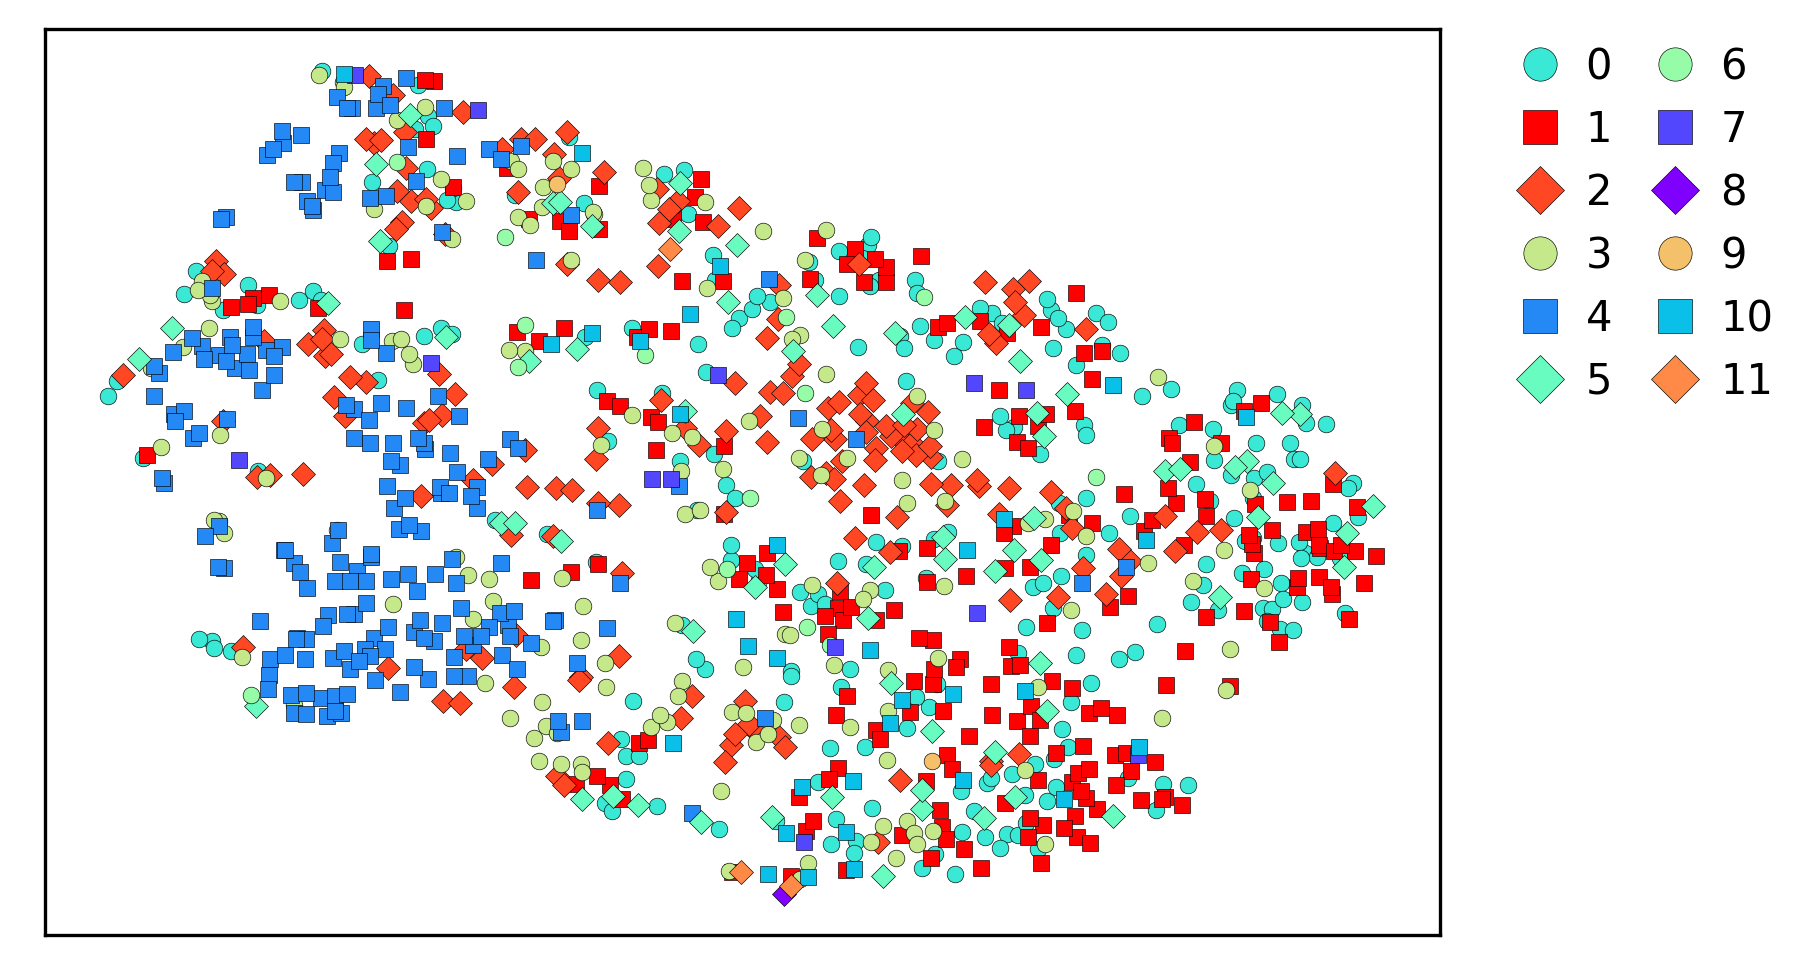

In [57]:
myscatter(ed, cells, legend=True)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.13404154777526855 seconds
Jaccard graph constructed in 0.362943172454834 seconds
Wrote graph to binary file in 0.02803516387939453 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.69042
After 2 runs, maximum modularity is Q = 0.694271
After 17 runs, maximum modularity is Q = 0.69561
Louvain completed 37 runs in 2.3942291736602783 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 3.121391773223877 seconds


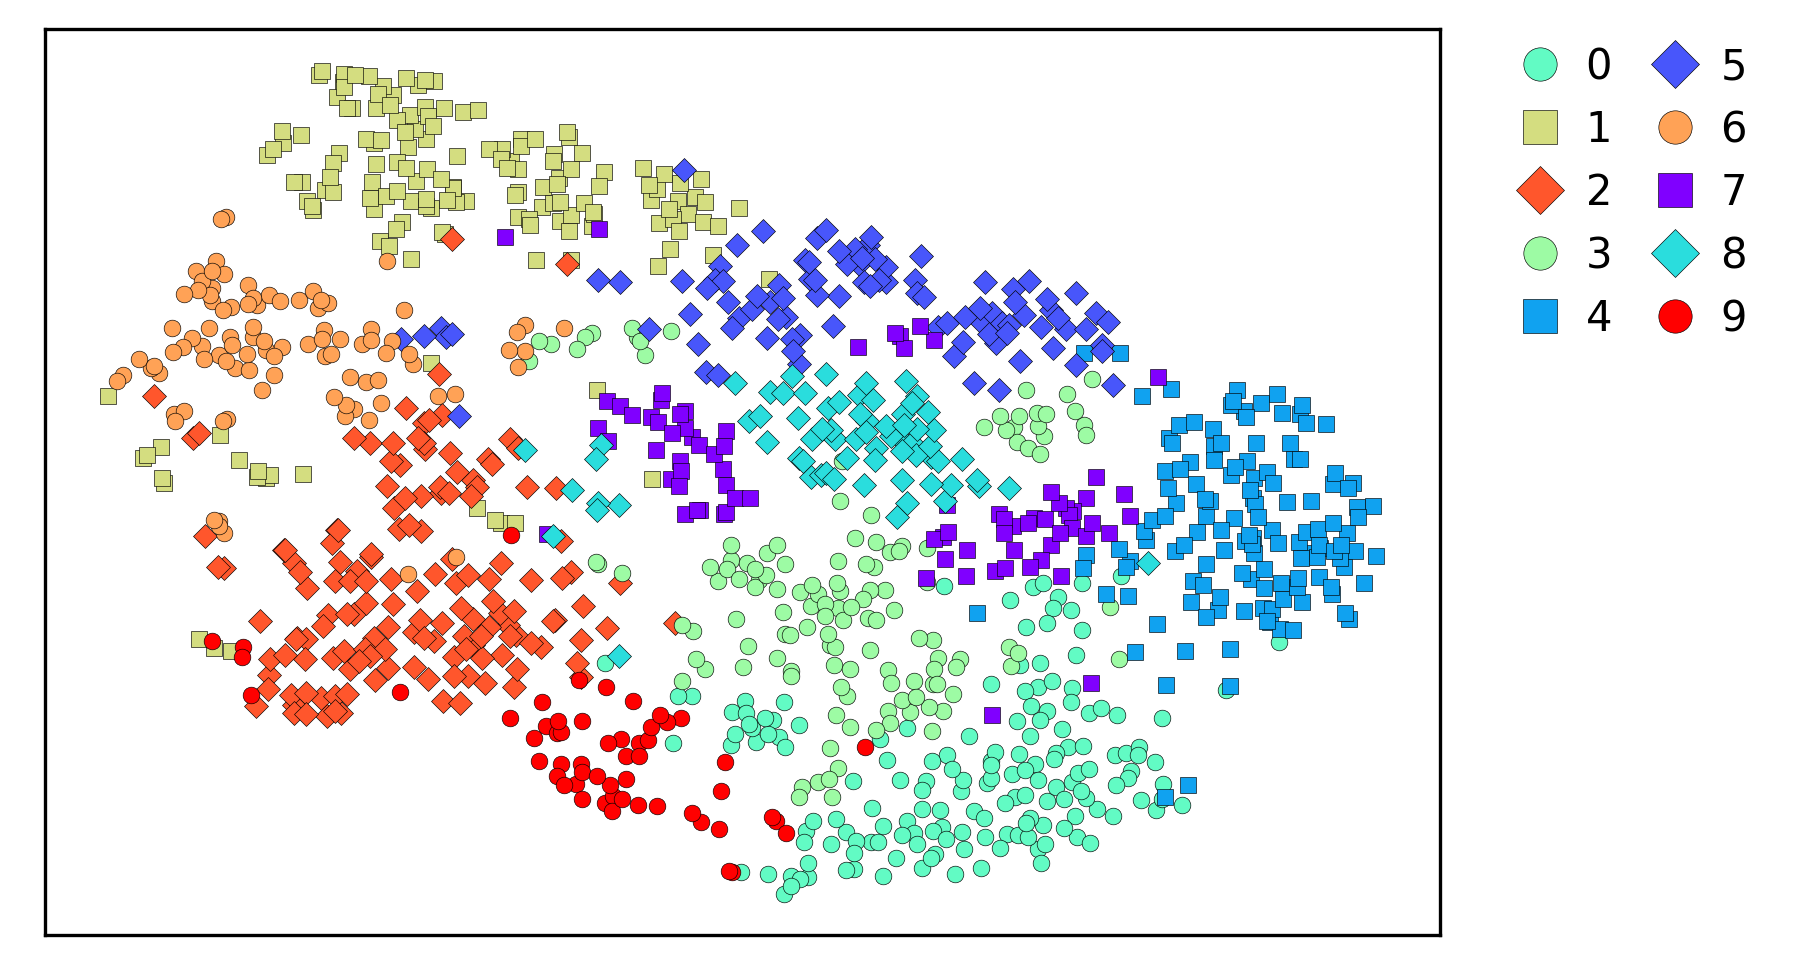

In [58]:
labels, _,  _ = phenograph.cluster(np.array(h))
myscatter(ed,labels, legend=True)

In [59]:
autoencoder.clustering_train(h, mode = "louvain", n_cluster = 10, wc=2.5, max_epoch=50)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.13916659355163574 seconds
Jaccard graph constructed in 0.3862898349761963 seconds
Wrote graph to binary file in 0.02235579490661621 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.693256
After 3 runs, maximum modularity is Q = 0.695148
After 9 runs, maximum modularity is Q = 0.696272
After 17 runs, maximum modularity is Q = 0.697325
Louvain completed 37 runs in 2.5758025646209717 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 3.320190668106079 seconds


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


tf.Tensor(0.92473865, shape=(), dtype=float32)
tf.Tensor(0.18618, shape=(), dtype=float32)
tf.Tensor(0.66715586, shape=(), dtype=float32)
tf.Tensor(0.09800111, shape=(), dtype=float32)
tf.Tensor(0.54154915, shape=(), dtype=float32)
tf.Tensor(0.05725825, shape=(), dtype=float32)
tf.Tensor(0.49283385, shape=(), dtype=float32)
tf.Tensor(0.04227419, shape=(), dtype=float32)
tf.Tensor(0.47312692, shape=(), dtype=float32)
tf.Tensor(0.036328305, shape=(), dtype=float32)
Finish!


In [60]:
h = autoencoder.encoder(x_train)

In [67]:
ed = tsne(h)

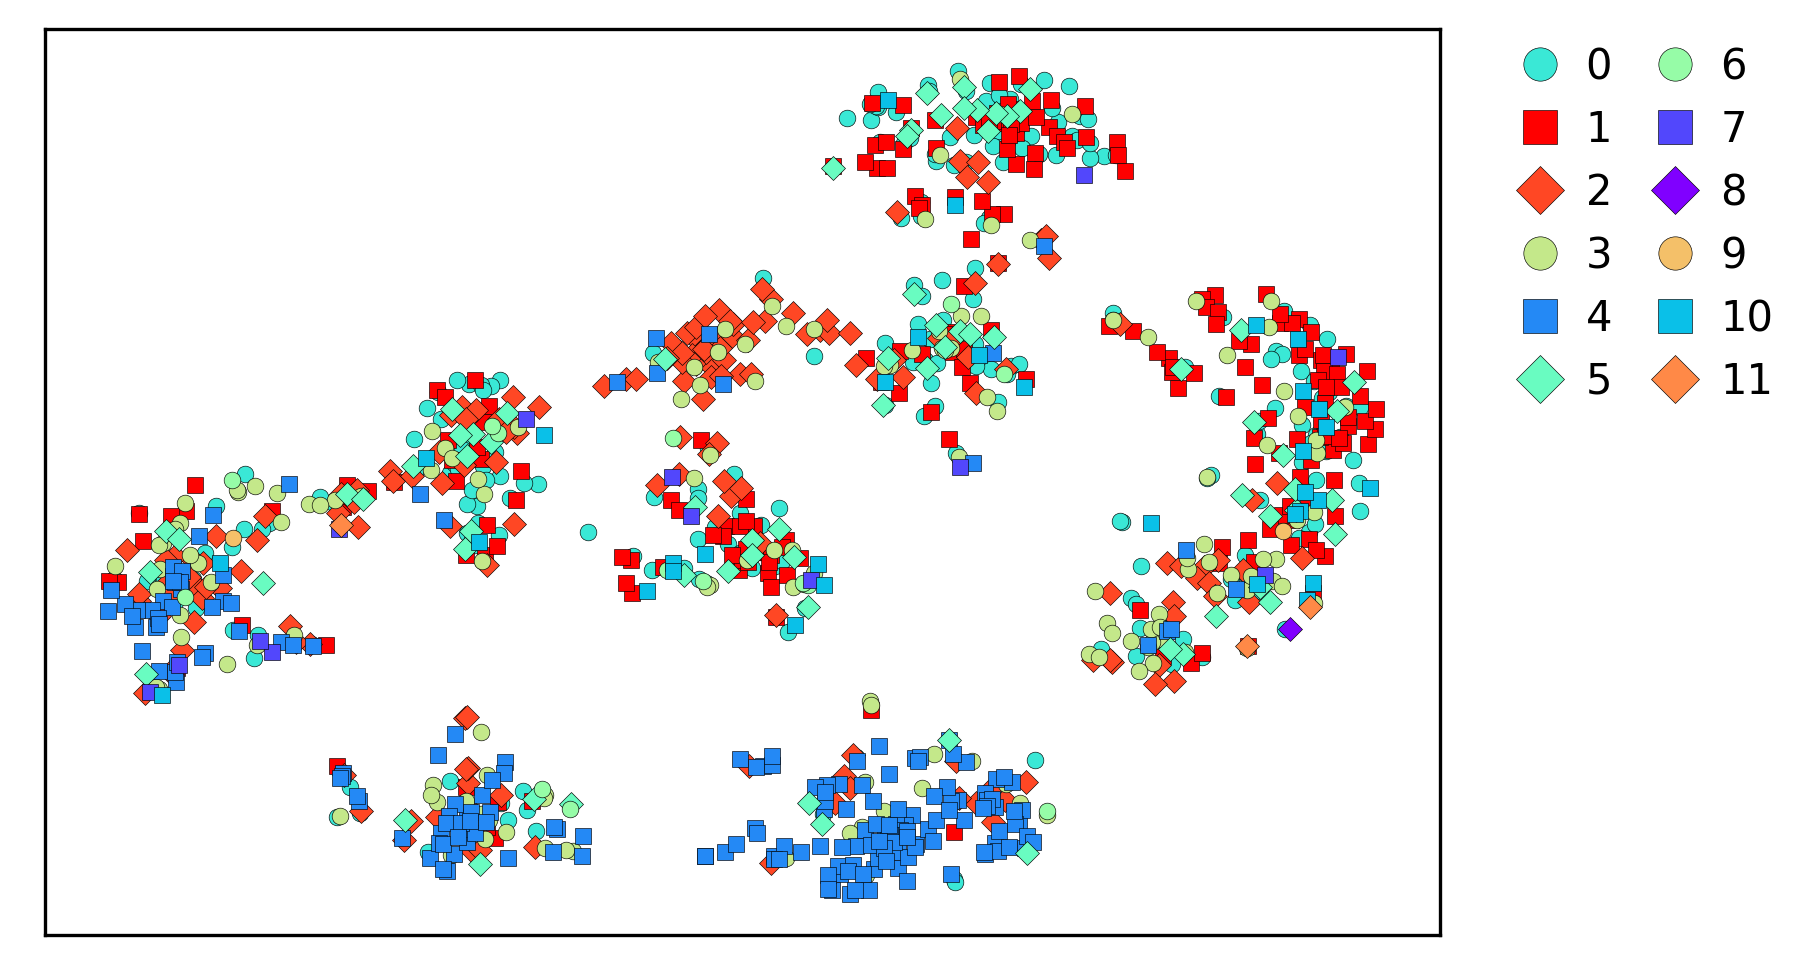

In [62]:
myscatter(ed, cells, legend=True)

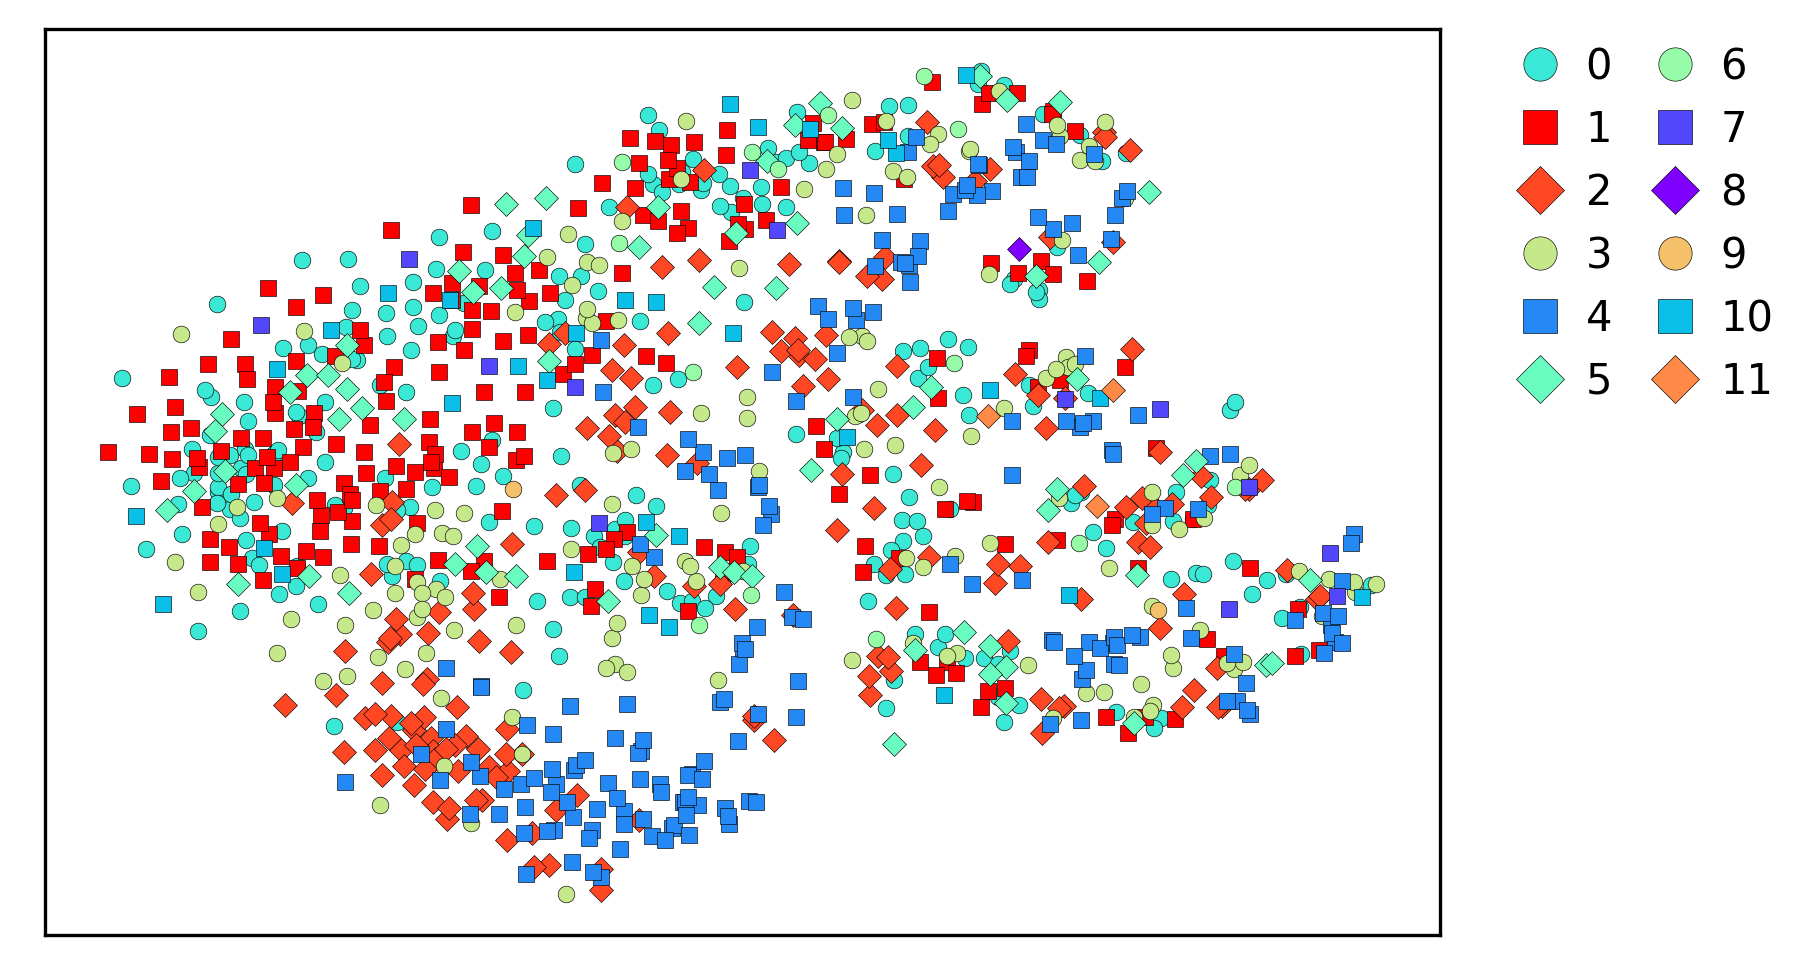

In [63]:
ed = tsne(count)
myscatter(ed, cells, legend=True)

In [64]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, homogeneity_score, completeness_score
def measure(true, pred):
    NMI = round(normalized_mutual_info_score(true, pred), 2)
    RAND = round(adjusted_rand_score(true, pred), 2)
    HOMO = round(homogeneity_score(true, pred), 2)
    COMP = round(completeness_score(true, pred), 2)
    return [NMI, RAND, HOMO, COMP]

In [68]:
labels_new, _,  _ = phenograph.cluster(np.array(h))
measure(cells, labels)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.13556861877441406 seconds
Jaccard graph constructed in 0.3865792751312256 seconds
Wrote graph to binary file in 0.023760318756103516 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.855867
Louvain completed 21 runs in 1.2139945030212402 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 1.9610402584075928 seconds


[0.18, 0.11, 0.19, 0.17]

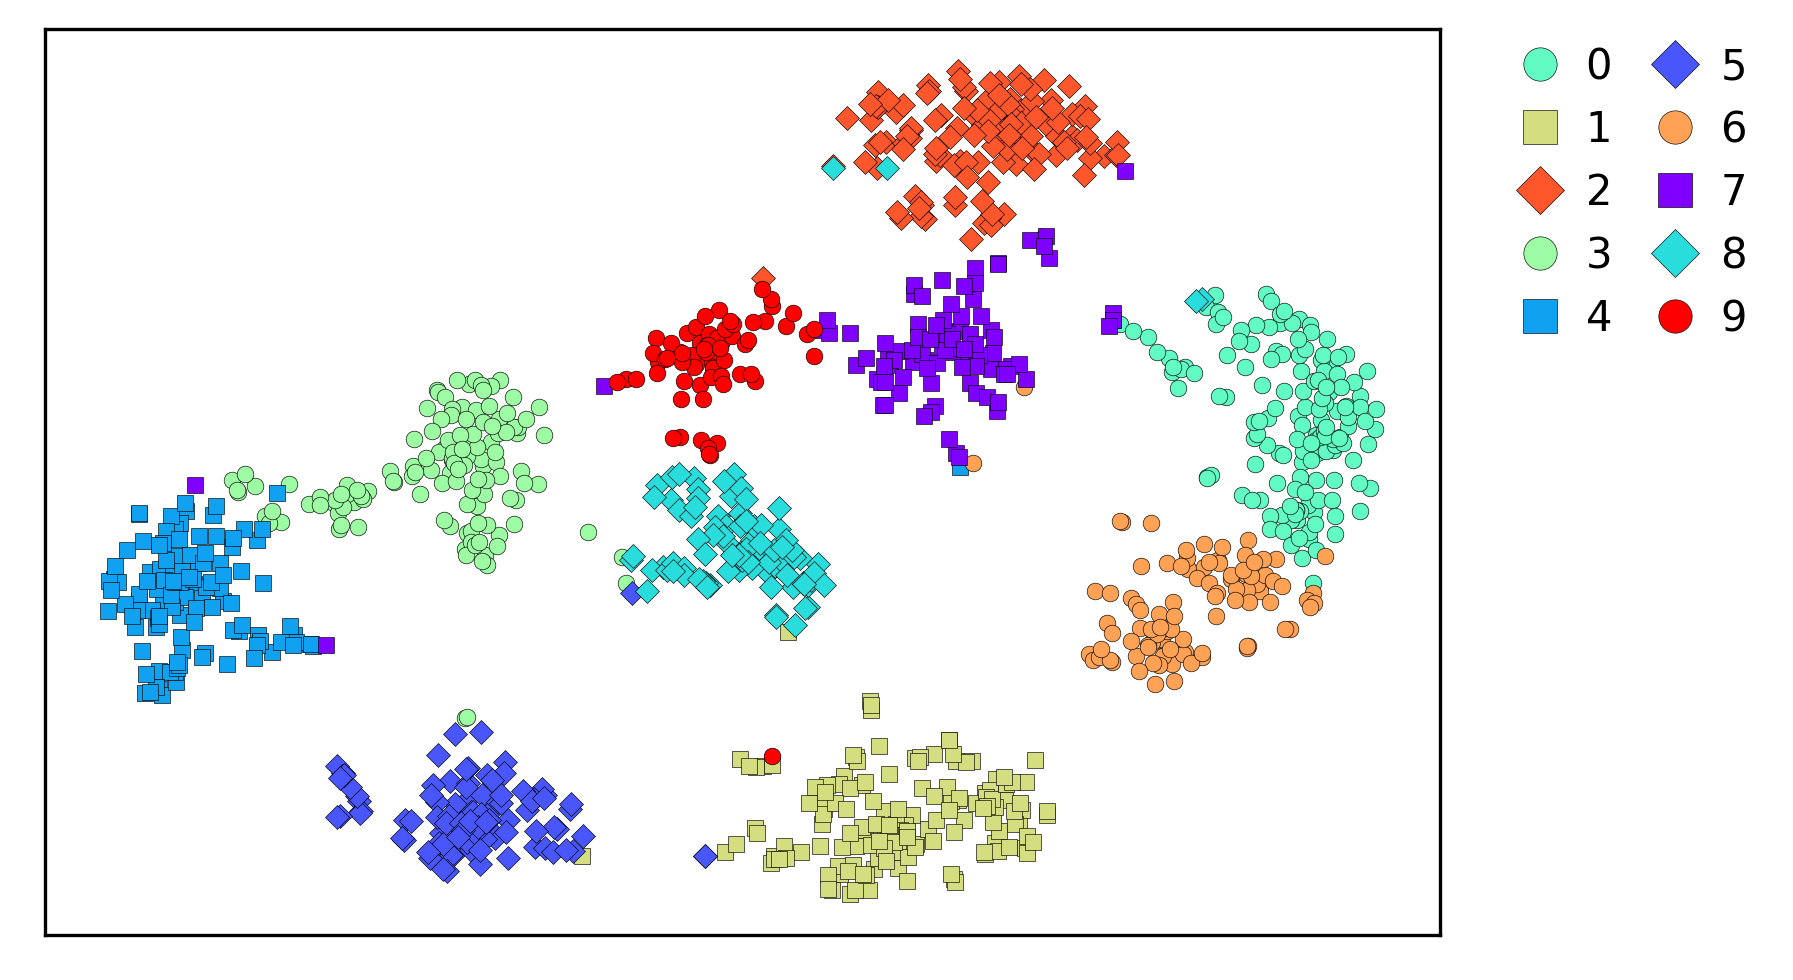

In [69]:
myscatter(ed, labels_new, legend=True)

In [ ]:
labels_new = KMeans(n_clusters=10, random_state=0).fit(np.array(h)).labels_
measure(cells, labels)

In [ ]:
myscatter(ed,labels_new, legend=True)

In [ ]:
from scipy.spatial.distance import cdist
dist_mat = cdist(h, h, 'euclidean')

In [ ]:
save = pd.DataFrame(dist_mat)
save.to_csv('GSM3587923_AML1012-D0_dist.csv',index=False,header=True)

In [70]:
y_test = cells
y_pred = labels_new

In [71]:
from sklearn.metrics import confusion_matrix

#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

[[ 41   6  56  38  17  12  18  26  24   3   0   0]
 [ 66   2  49  23   9   9  13  22  28   1   0   0]
 [  4  13   7  28  25  14  18  18   8  45   0   0]
 [ 13  15   6  16  19  19  30  14  10  12   0   0]
 [  0 108   0   3  37  39   6   2   0   6   0   0]
 [ 12   4  12  11   5   4   5   9   9   1   0   0]
 [  0   1   0   3   1   2   0   2   4   1   0   0]
 [  1   0   1   2   5   0   1   0   3   0   0   0]
 [  0   0   0   0   0   0   1   0   0   0   0   0]
 [  1   0   0   0   1   0   0   0   0   0   0   0]
 [ 12   0   2   3   2   0   4   3   7   0   0   0]
 [  0   0   0   1   0   0   2   0   0   0   0   0]]
